# Balanced Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the Balanced data set. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Balanced Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is worth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. The Focused dataset consists on the compilation of all data points that characterize as constraints. However, the model might lack the hability to predict the non-occurence of constraints, since the dataset is not balanced. To solve this problem, the dataset is balanced by randomly sampling the non-constraint data points.

In [1]:
import sys; sys.path.append('..')
from thesis_package import utils

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

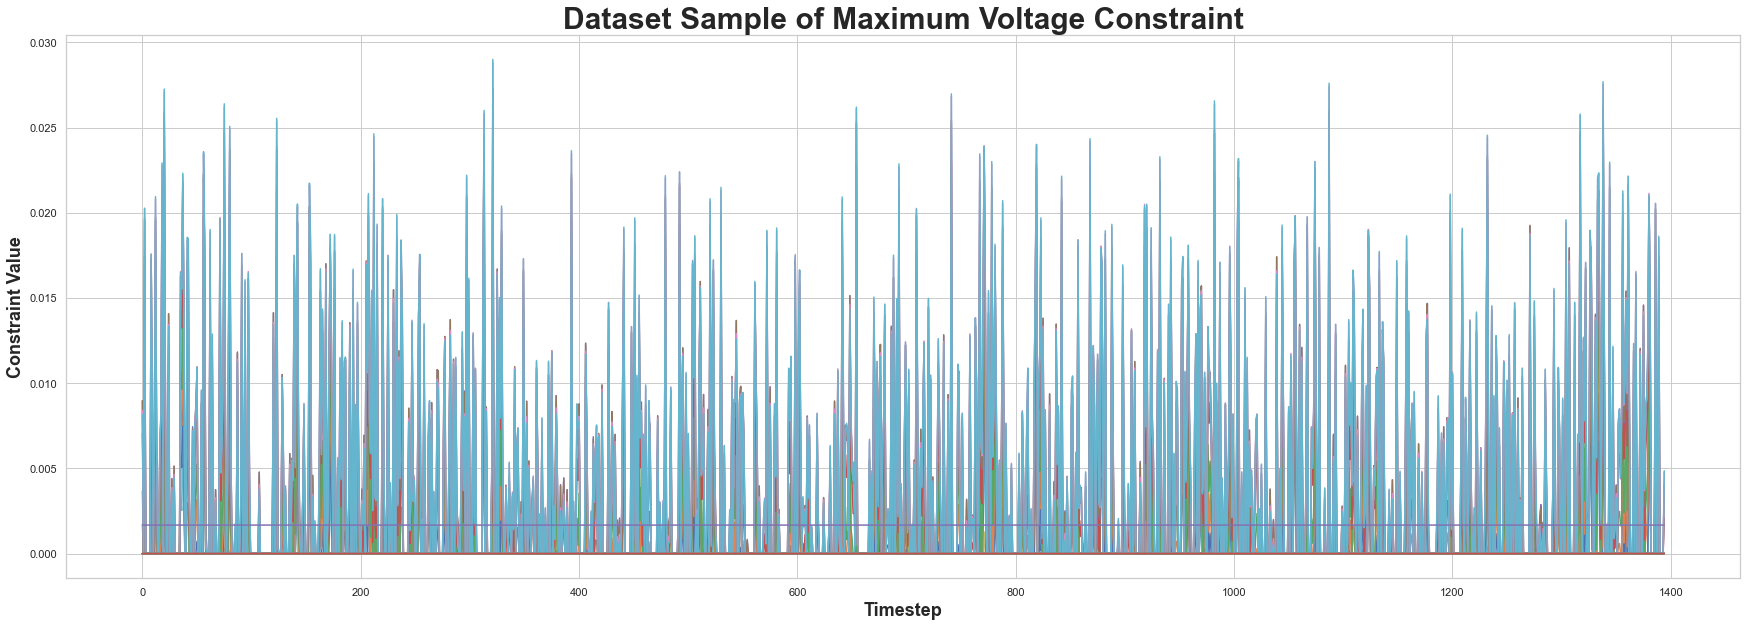

In [2]:
y_max_u_balanced = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
exogenous_data_vm_pu_max_balanced = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data_vm_pu_max_balanced, y_max_u_balanced)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

## Import Libraries

In [3]:
import optuna 
import os

import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils, metrics

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [4]:
# General parameters
num_trials = 50

### Extreme Gradient Boosting Regressor

In [5]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_balanced_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-24 23:12:34,183] A new study created in memory with name: no-name-63ef46d5-0152-4380-9b59-737686cc87a5
[I 2022-09-24 23:12:54,416] Trial 0 finished with value: 0.6625816673381952 and parameters: {'booster': 'gblinear', 'lambda': 0.0004981040674279508, 'alpha': 0.0005276962246797066, 'subsample': 0.5629223756816237, 'colsample_bytree': 0.6277776440229761}. Best is trial 0 with value: 0.6625816673381952.
[I 2022-09-24 23:13:15,734] Trial 1 finished with value: 0.6404646139047203 and parameters: {'booster': 'gblinear', 'lambda': 0.2206358934930581, 'alpha': 5.039095246604581e-07, 'subsample': 0.31263120161497926, 'colsample_bytree': 0.20944787052538807}. Best is trial 0 with value: 0.6625816673381952.
[I 2022-09-24 23:14:04,876] Trial 2 finished with value: 0.21947990927217986 and parameters: {'booster': 'gbtree', 'lambda': 4.355952641208219e-08, 'alpha': 0.0019037467095918193, 'subsample': 0.3237770908928222, 'colsample_bytree': 0.6177963712983003, 'max_depth': 9, 'min_child_w

Number of finished trials:  50
Best trial:
  Value: 0.8206199571838381
  Params: 
    booster: gbtree
    lambda: 2.7672083092013075e-06
    alpha: 3.290882841064105e-08
    subsample: 0.7299372589310998
    colsample_bytree: 0.7697558364196286
    max_depth: 7
    min_child_weight: 3
    eta: 0.02942913923800093
    gamma: 3.363098771057399e-08
    grow_policy: depthwise


In [6]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_balanced_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 15:13:40,204] A new study created in memory with name: no-name-fae76dbd-d7c6-4994-be28-7377f1e71f91
[I 2022-09-25 15:14:25,122] Trial 0 finished with value: 0.7677136570374338 and parameters: {'booster': 'gbtree', 'lambda': 6.442148445247124e-07, 'alpha': 1.5666827007797367e-08, 'subsample': 0.27482981492050995, 'colsample_bytree': 0.41087933949320504, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.3594589389969743, 'gamma': 0.008389779470366877, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.7677136570374338.
[I 2022-09-25 15:20:52,331] Trial 1 finished with value: 0.7237070988441634 and parameters: {'booster': 'dart', 'lambda': 0.12812862946998507, 'alpha': 9.425317337034333e-06, 'subsample': 0.85824294351285, 'colsample_bytree': 0.5537163962194933, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.020311455228500065, 'gamma': 2.1527662181331765e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0515657413685

Number of finished trials:  50
Best trial:
  Value: 0.7975742183383274
  Params: 
    booster: dart
    lambda: 3.0688194641631903e-06
    alpha: 0.026682455376267594
    subsample: 0.8323024765852791
    colsample_bytree: 0.6500191262073954
    max_depth: 7
    min_child_weight: 9
    eta: 0.032163120007348896
    gamma: 3.740358761831146e-08
    grow_policy: lossguide
    sample_type: uniform
    normalize_type: tree
    rate_drop: 6.631337451389453e-05
    skip_drop: 1.7796717715387674e-05


### Gradient Boosting Regressor

In [7]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_balanced_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 17:42:17,505] A new study created in memory with name: no-name-fbda1914-8bbe-4f56-87c3-511a5569ddbb
[I 2022-09-25 17:42:55,505] Trial 0 finished with value: 0.799311738398391 and parameters: {'n_estimators': 81, 'learning_rate': 0.2996762779734202, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.799311738398391.
[I 2022-09-25 17:48:45,080] Trial 1 finished with value: 0.7895266991290055 and parameters: {'n_estimators': 974, 'learning_rate': 0.10518830386153086, 'loss': 'squared_error'}. Best is trial 0 with value: 0.799311738398391.
[I 2022-09-25 17:49:25,726] Trial 2 finished with value: 0.7899148280150938 and parameters: {'n_estimators': 98, 'learning_rate': 0.8422794701780433, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.799311738398391.
[I 2022-09-25 17:50:16,819] Trial 3 finished with value: 0.789411096510874 and parameters: {'n_estimators': 125, 'learning_rate': 0.6560987016302489, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.7993117

Number of finished trials:  50
Best trial:
  Value: 0.8047837141310673
  Params: 
    n_estimators: 84
    learning_rate: 0.10196039082902036
    loss: squared_error


In [8]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_balanced_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 18:32:12,833] A new study created in memory with name: no-name-e9a28823-a754-47fd-ba8e-6a1fd4d7956d
[I 2022-09-25 18:33:40,186] Trial 0 finished with value: 0.7872463196958597 and parameters: {'n_estimators': 111, 'learning_rate': 0.37953177685357453, 'loss': 'squared_error'}. Best is trial 0 with value: 0.7872463196958597.
[I 2022-09-25 18:34:30,936] Trial 1 finished with value: 0.781844607847638 and parameters: {'n_estimators': 58, 'learning_rate': 0.2864825654339937, 'loss': 'squared_error'}. Best is trial 0 with value: 0.7872463196958597.
[I 2022-09-25 18:35:22,082] Trial 2 finished with value: 0.7844954000645084 and parameters: {'n_estimators': 52, 'learning_rate': 0.5121151665534599, 'loss': 'squared_error'}. Best is trial 0 with value: 0.7872463196958597.
[I 2022-09-25 18:36:02,965] Trial 3 finished with value: 0.7790345151130722 and parameters: {'n_estimators': 34, 'learning_rate': 0.5752314374402353, 'loss': 'squared_error'}. Best is trial 0 with value: 0.7872463

Number of finished trials:  50
Best trial:
  Value: 0.8008882601031363
  Params: 
    n_estimators: 405
    learning_rate: 0.21678392195811974
    loss: squared_error


### Support Vector Regressor

In [9]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_balanced_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 22:10:12,971] A new study created in memory with name: no-name-0957eb26-9d03-4d8f-ad51-45bedfd937d6
[I 2022-09-25 22:10:33,847] Trial 0 finished with value: 0.3880372778313655 and parameters: {'kernel': 'poly', 'C': 3.2960692655066146e-08, 'degree': 2, 'gamma': 0.0005809620598215546}. Best is trial 0 with value: 0.3880372778313655.
[I 2022-09-25 22:10:55,872] Trial 1 finished with value: 0.3965427296203386 and parameters: {'kernel': 'poly', 'C': 3.496678292119322e-08, 'degree': 4, 'gamma': 0.0014950403032733574}. Best is trial 1 with value: 0.3965427296203386.
[I 2022-09-25 22:11:30,638] Trial 2 finished with value: 0.4110311698124584 and parameters: {'kernel': 'rbf', 'C': 5.855475418583017e-06, 'degree': 4, 'gamma': 0.09983246981839264}. Best is trial 2 with value: 0.4110311698124584.
[I 2022-09-25 22:11:52,538] Trial 3 finished with value: 0.38938541313715525 and parameters: {'kernel': 'poly', 'C': 2.3661367227790558e-05, 'degree': 2, 'gamma': 3.45348373729088e-06}. Bes

Number of finished trials:  50
Best trial:
  Value: 0.8116363255643548
  Params: 
    kernel: poly
    C: 0.8152518433534094
    degree: 5
    gamma: 0.4110716960815


In [10]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_min_u.columns)
    valid_y = pd.DataFrame(valid_y, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    threshold = valid_y.loc[:, valid_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.hybrid_f1
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_balanced_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 22:31:40,453] A new study created in memory with name: no-name-f43db75f-a529-4eab-8ea0-95dc8ca17610
[I 2022-09-25 22:32:58,100] Trial 0 finished with value: 0.5422529198130557 and parameters: {'kernel': 'rbf', 'C': 0.28007482055143584, 'degree': 1, 'gamma': 0.00018111405671848499}. Best is trial 0 with value: 0.5422529198130557.
[I 2022-09-25 22:34:10,040] Trial 1 finished with value: 0.3921668747495629 and parameters: {'kernel': 'rbf', 'C': 0.47945575284213493, 'degree': 4, 'gamma': 3.023907000248084e-08}. Best is trial 0 with value: 0.5422529198130557.
[I 2022-09-25 22:34:57,075] Trial 2 finished with value: 0.546660702499063 and parameters: {'kernel': 'poly', 'C': 0.30442695648949214, 'degree': 3, 'gamma': 0.019831373390643642}. Best is trial 2 with value: 0.546660702499063.
[I 2022-09-25 22:36:18,440] Trial 3 finished with value: 0.38695262792925367 and parameters: {'kernel': 'rbf', 'C': 0.05409378600031932, 'degree': 1, 'gamma': 3.290114190349659e-07}. Best is trial 

Number of finished trials:  50
Best trial:
  Value: 0.7814216257890312
  Params: 
    kernel: rbf
    C: 0.7099331389181525
    degree: 2
    gamma: 0.9790446040825302


# Extreme Gradient Boost Classifier

In [11]:
def objective(trial):
    # import data
    y_max_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv')
    y_max_u_balanced_bool = utils.convert_df_to_bool(y_max_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_balanced_bool[utils.cols_with_positive_values(y_max_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_balanced_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 23:21:02,253] A new study created in memory with name: no-name-738d60bd-4498-4b43-bd01-f799718d2b66
[I 2022-09-25 23:21:28,633] Trial 0 finished with value: 0.5559053296822991 and parameters: {'booster': 'dart', 'lambda': 3.4913702635583065e-06, 'alpha': 7.077488357313312e-06, 'subsample': 0.5117068620689771, 'colsample_bytree': 0.658896574844201, 'max_depth': 3, 'min_child_weight': 7, 'eta': 2.636972697707185e-06, 'gamma': 0.05866413353456156, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1038531122792722e-08, 'skip_drop': 0.001287068636278043}. Best is trial 0 with value: 0.5559053296822991.
[I 2022-09-25 23:21:35,516] Trial 1 finished with value: 0.4520358617745187 and parameters: {'booster': 'gbtree', 'lambda': 5.91363953967255e-07, 'alpha': 5.859705912376179e-07, 'subsample': 0.4705847083803466, 'colsample_bytree': 0.24383301855260067, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.8284840350050196e-08, 'gamma': 0.00

Number of finished trials:  50
Best trial:
  Value: 0.665520355433705
  Params: 
    booster: dart
    lambda: 0.00015884090078506437
    alpha: 0.19774958488491742
    subsample: 0.7634517553183634
    colsample_bytree: 0.824966208242803
    max_depth: 5
    min_child_weight: 8
    eta: 0.1039306615628526
    gamma: 0.6835098793603533
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: tree
    rate_drop: 4.7305061368641385e-05
    skip_drop: 4.6864756927258716e-05


In [12]:
def objective(trial):
    # import data
    y_min_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv')
    y_min_u_balanced_bool = utils.convert_df_to_bool(y_min_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_balanced_bool[utils.cols_with_positive_values(y_min_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_balanced_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 23:38:54,543] A new study created in memory with name: no-name-e38d4f15-8292-4248-b9ae-911a557870a8
[I 2022-09-25 23:39:10,187] Trial 0 finished with value: 0.6849638101306204 and parameters: {'booster': 'gbtree', 'lambda': 1.7105406543472956e-08, 'alpha': 3.6914201583457594e-05, 'subsample': 0.3870237425132551, 'colsample_bytree': 0.6892340039269607, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.24339145137876886, 'gamma': 0.0031787498135114433, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6849638101306204.
[I 2022-09-25 23:39:52,958] Trial 1 finished with value: 0.30135587889762333 and parameters: {'booster': 'dart', 'lambda': 7.699086319213787e-06, 'alpha': 5.395413111930841e-05, 'subsample': 0.9719236962852302, 'colsample_bytree': 0.29489405647982025, 'max_depth': 3, 'min_child_weight': 4, 'eta': 2.3559069968964516e-08, 'gamma': 7.806704580339083e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.5646

Number of finished trials:  50
Best trial:
  Value: 0.6966389919995043
  Params: 
    booster: gbtree
    lambda: 4.054592530775095e-05
    alpha: 5.174708824228512e-05
    subsample: 0.8469092367338825
    colsample_bytree: 0.5847478326272141
    max_depth: 5
    min_child_weight: 6
    eta: 0.2768740439937659
    gamma: 3.1155873290293454e-06
    grow_policy: depthwise


## Grandient Boost Classifier


In [13]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_max_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv')
    y_max_u_balanced_bool = utils.convert_df_to_bool(y_max_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_balanced_bool[utils.cols_with_positive_values(y_max_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the classification performance f1 score
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='micro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_balanced_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-25 23:55:05,671] A new study created in memory with name: no-name-51d90209-2891-4ed2-9aee-cdf765804a01
[I 2022-09-25 23:57:52,562] Trial 0 finished with value: 0.8086064548411309 and parameters: {'n_estimators': 688, 'learning_rate': 0.21370137680760606, 'loss': 'log_loss'}. Best is trial 0 with value: 0.8086064548411309.
[I 2022-09-25 23:59:00,923] Trial 1 finished with value: 0.8129478626142822 and parameters: {'n_estimators': 261, 'learning_rate': 0.17544682425521424, 'loss': 'exponential'}. Best is trial 1 with value: 0.8129478626142822.
[I 2022-09-25 23:59:06,373] Trial 2 finished with value: 0.8041362530413625 and parameters: {'n_estimators': 19, 'learning_rate': 0.6249721721134788, 'loss': 'log_loss'}. Best is trial 1 with value: 0.8129478626142822.
[I 2022-09-25 23:59:28,703] Trial 3 finished with value: 0.809500369185331 and parameters: {'n_estimators': 83, 'learning_rate': 0.22551692250446126, 'loss': 'log_loss'}. Best is trial 1 with value: 0.8129478626142822.
c:\

Number of finished trials:  50
Best trial:
  Value: 0.8267361934107609
  Params: 
    n_estimators: 31
    learning_rate: 0.1337791953835611
    loss: exponential


In [14]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_min_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv')
    y_min_u_balanced_bool = utils.convert_df_to_bool(y_min_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_balanced_bool[utils.cols_with_positive_values(y_min_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the classification performance f1 score
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='micro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_balanced_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-26 00:15:46,458] A new study created in memory with name: no-name-18be702c-317f-4bcb-8406-fc9064852490
[I 2022-09-26 00:19:36,311] Trial 0 finished with value: 0.8144889279953073 and parameters: {'n_estimators': 461, 'learning_rate': 0.5704966715603718, 'loss': 'log_loss'}. Best is trial 0 with value: 0.8144889279953073.
[I 2022-09-26 00:21:28,596] Trial 1 finished with value: 0.8248116450881429 and parameters: {'n_estimators': 235, 'learning_rate': 0.2644187962877815, 'loss': 'log_loss'}. Best is trial 1 with value: 0.8248116450881429.
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\

Number of finished trials:  50
Best trial:
  Value: 0.8315464825965634
  Params: 
    n_estimators: 872
    learning_rate: 0.1641390435327391
    loss: exponential


## Support Vector Classifier

In [15]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_max_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv')
    y_max_u_balanced_bool = utils.convert_df_to_bool(y_max_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_balanced_bool[utils.cols_with_positive_values(y_max_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_balanced_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-26 03:19:08,608] A new study created in memory with name: no-name-905d1d9c-1c69-46c6-95bb-a29597fd2325
[I 2022-09-26 03:19:37,610] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.0001336983771521416, 'degree': 3, 'gamma': 8.577019124577317e-07}. Best is trial 0 with value: 0.0.
[I 2022-09-26 03:19:51,545] Trial 1 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 9.618574874775259e-06, 'degree': 2, 'gamma': 1.0358602298179526e-05}. Best is trial 0 with value: 0.0.
[I 2022-09-26 03:20:24,739] Trial 2 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.00019553855662838323, 'degree': 1, 'gamma': 0.001879451197819718}. Best is trial 0 with value: 0.0.
[I 2022-09-26 03:20:40,170] Trial 3 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 2.270972851511168e-05, 'degree': 4, 'gamma': 9.25966408067636e-07}. Best is trial 0 with value: 0.0.
[I 2022-09-26 03:20:55,213] Trial 4 finished with value: 0.0 and parameters:

Number of finished trials:  50
Best trial:
  Value: 0.5913751754094161
  Params: 
    kernel: rbf
    C: 0.41893172852224936
    degree: 2
    gamma: 0.8207285355315294


In [16]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_min_u_balanced_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv')
    y_min_u_balanced_bool = utils.convert_df_to_bool(y_min_u_balanced_bool)
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_balanced_bool[utils.cols_with_positive_values(y_min_u_balanced_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # classification performance
    f1_score = sklearn.metrics.f1_score(valid_y, prediction, average='macro')
    return f1_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_balanced_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-09-26 03:38:01,223] A new study created in memory with name: no-name-5eb93039-97dd-4581-9c24-1afba6d27d1b
[I 2022-09-26 03:39:32,533] Trial 0 finished with value: 0.06570188133140377 and parameters: {'kernel': 'rbf', 'C': 0.001010576807775391, 'degree': 4, 'gamma': 1.319500162758175e-08}. Best is trial 0 with value: 0.06570188133140377.
[I 2022-09-26 03:40:19,089] Trial 1 finished with value: 0.06570188133140377 and parameters: {'kernel': 'poly', 'C': 0.001102544502153014, 'degree': 2, 'gamma': 0.00035924683196095225}. Best is trial 0 with value: 0.06570188133140377.
[I 2022-09-26 03:41:04,972] Trial 2 finished with value: 0.06570188133140377 and parameters: {'kernel': 'poly', 'C': 0.020838466670605762, 'degree': 2, 'gamma': 2.844046294395291e-08}. Best is trial 0 with value: 0.06570188133140377.
[I 2022-09-26 03:41:50,465] Trial 3 finished with value: 0.06570188133140377 and parameters: {'kernel': 'poly', 'C': 7.3869447515029645e-06, 'degree': 1, 'gamma': 0.005245442660500256}

Number of finished trials:  50
Best trial:
  Value: 0.605450210300487
  Params: 
    kernel: rbf
    C: 0.7018071100873359
    degree: 2
    gamma: 0.8564841524851309
